# Visual Question Answering

In this assignment, you'll gain experience working with multi-input models. You'll develop a model that takes a question and an image as input, and returns a yes/no answer in response. You'll also gain experience working with (and preprocessing) large datasets.

You are welcome to implement your model using either Model Subclassing or the Functional API. I suggest using the Functional API, it's worth gaining experience with, so you're familiar with it if you see it in code examples down the road. In either case, you will likely spend more time preparing and preprocessing the dataset than you will developing the model (as is usually the case in ML).

## Your starter dataset

The [VQA dataset](https://visualqa.org/download.html) includes images and JSON containing the questions and answers. To save you time parsing the JSON (and various other preprocessing work), we've prepared a subset of the dataset for you in an easier to read CSV file for you.

You should download your starter dataset from [here](https://storage.cloud.google.com/applied-dl/mini-vqa/starter2.csv).

Your starter CSV has three columns, giving the question, answer, and image.

question|answer|image
:-----:|:-----:|:-----:
is the sky blue|yes|COCO\_train2014\_000000393221.jpg
is there snow on the mountains|yes|COCO\_train2014\_000000393221.jpg
is the window open|no|COCO\_train2014\_000000393223.jpg

### Notes on how this was prepared.
* The starter dataset contains all the "yes" / "no" questions from the VQA v2 training annotations.
* The answers are the most frequent one to the question (ties broken randomly).
* The text has been standardized (it's in lowercase, and punctuation has been removed).
* There are 20,000 question / image pairs.
* Each image and question is used exactly once.
* The image filenames correspond to the [COCO 2014 training images](http://images.cocodataset.org/zips/train2014.zip). Note this file is about 11GB. You will need to download this later.

### A note on downloading the COCO training images

The training images are large (around 11GB), and you may not want to download them repeatedly in Colab (if your instance restarts, you will not want to have to download and preprocess an 11GB file all over again). Continue reading this assignment for tips.

Your workflow for this assignment will be to:

**Part 1**: Create a new notebook called "preprocessing.ipynb". In this notebook, you will create a smaller dataset that contains a subset of the training images. This will simplify your experiment. Do to so, you will:
- Download the training images.
- Preprocess the images referenced in the starter CSV (by resizing them to 299x299). The starter CSV uses only a small fraction of the available images in the COCO dataset. You can disgard the unused images (e.g., by deleting them to free up disk space).
- Create a zip file containing only the preprocessed images from the starter dataset (it should be about 500MB) and host that on the cloud.
- To host your zip on the cloud, you can use any Cloud service (for example, [Cloud storage](https://cloud.google.com/storage/docs/creating-buckets)). You do not need to pay for a cloud solution for this class (Google Cloud, for example, has a [free](https://cloud.google.com/free) tier you can use). Many other providers like Amazon and Microsoft also have free (or very low cost) storage options.

**Part 2**:
- Complete this notebook, following the instrutions below.
- Download your simplfiied 500MB zip containing the preprocessed training images you created above using a command like ```!wget```, or the code shown below.
- Note **You do not need to achieve high accuracy on the validation set for this assignment** (it will be difficult given the small dataset you'll use). To receive full credit, you should aim for high training accuracy on the training set, and clean well-commented code. It is okay for your model to overfit.

### A note on creating and training your model

You can find an example VQA model at the bottom of this notebook that you can use as a starting point. Feel free to rewrite or improve this in any way you like. Note: in addition the model, there are many parameters you can explore that may impact accuracy when you preprocess the data (vocabulary size, sequence length).

Notes:
* Instead of training a CNN from scratch, you will use a pretrained model (Inception-V3) and cache the activations to disk.
* Your VQA model will take a while to train. It is important that you save a [checkpoint](https://www.tensorflow.org/guide/keras/save_and_serialize) to disk after each epoch (or every several epochs), so you can resume training from where you left off if you loose your connection to Colab. Before training your model, check for existing checkpoints, and load the latest one to resume training.

Training tips:

* Code defensively and get to know your data. There will be several preprocessing steps (resizing images, caching activations, tokenization, padding, etc). **After each one, write a short block of code to verify the output is correct.** The sooner you catcher errors, the easier it will be to have confidence that your entire program works correctly.

* When developing a complex model, you can consider fitting your model on a single batch first (e.g., repeatedly train on the same batch of 32 examples and labels) to ensure your model is working correctly. Verify your model can successfully memorize this data (the loss should go to zero). If not, it's likely you have a bug (either in your data preparation, or in your model itself). For tips, see this  blog post: [A recipe for training NNs](http://karpathy.github.io/2019/04/25/recipe/).

* Next, write code to make predictions on each image from a single batch, and display the image, question, and answer. Make sure the results are sensible.

* As always, start with a simple model, get that working end-to-end, then gradually scale up.

## Starter code

The starter code below contains various blocks you can use for your two notebooks (the first to download and preprocess the data, the second to train your model).

## Submission instructions

Please submit this assignment on CourseWorks by uploading a zip containing your preprocessing notebook and this file (both should include saved output).

In [ ]:
!pip install Pillow # used to resize images

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import random
import shutil
import time
import glob
from sklearn.model_selection import train_test_split

from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf

## Notebook two: Preprocessing and training
Create a new notebook for this. Near the top of your notebook, download your starter CSV and thumbnails.zip. This way you can separate the part of your code that reads your data and trains a model from the part that prepares the dataset.

The starter code below assumes you have created a zip file called "thumbnails.zip" containing only the resized images from the COOC training set mentioned in the starter CSV, and that you can download it from a URL.

In [ ]:
# Starter code to download small files
# Use this to download your starter CSV in notebook one and two.
# Also use it to download your thumbnails.zip in notebook two.
def download_if_missing(url, target, extract=True):
  if os.path.exists(target):
    return target
  return tf.keras.utils.get_file(target, origin=url, extract=extract)

In [ ]:
colab_root = "/content/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download the starter CSV

In [ ]:
csv_path = os.path.join(colab_root, "starter2.csv")
download_if_missing("https://storage.googleapis.com/applied-dl/mini-vqa/starter2.csv",
                     csv_path)

'/content/starter2.csv'

In [ ]:
starter_dir = '/content/starter2.csv'
df = pd.read_csv(starter_dir,
                  names=["question", "Answer", "picture"])

### Download and unzip your thumbnails

This file is small enough that you can quickly download it with this method.

In [ ]:
# If you run the two parts separately, needs to coppy
# zip file from google drive with code
!cp -av '/content/drive/MyDrive/Colab_Notebooks/ADL_HW3/thumbnails.zip' "/content/"

In [ ]:
# Your code here
# Add a path to the zip you created and hosted on the cloud in part 1
# if you run this part right after the part 1 you can run this code
YOUR_THUMBNAILS_URL = '/content/thumbnails.zip'

In [ ]:
thumbnails_file = os.path.join(colab_root, "thumbnails.zip")
images_folder = os.path.join(colab_root, 'thumbnails/')
download_if_missing(YOUR_THUMBNAILS_URL,
                    thumbnails_file,
                    extract=False)

'/content/thumbnails.zip'

In [ ]:
!unzip -q $thumbnails_file -d $images_folder

replace /content/thumbnails/COCO_train2014_000000275771.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls $images_folder

### Sanity check

At this point, you have all the data you need to train your model (questions, answers, and images) in a convenient and easy to read format.

Now would be a good time for another santity check. Write a block of code to iterate over the starter CSV file. For each image, make sure you can locate it on disk. E.g.,

```
for question, answer, image_name in data:
  img_path = os.path.join(images_folder, image_name)
  assert os.path.exists(img_path)
```

Since you're working in a new notebook, again display a few questions, answers, and images - verify everything works as expected.

In [ ]:
data_dir = '/content/thumbnails'
training_pic_dir = os.listdir(data_dir)

find_all = True
while find_all:
    for i in range(len(df)):
        image_file = df.iloc[i]['picture']
        if image_file not in training_pic_dir:
            find_all = False
            print(f"{image_file} not found")
    print("All pictures were found in the unzipped thumbnails folder")
    find_all = False

All pictures were found in the unzipped thumbnails folder


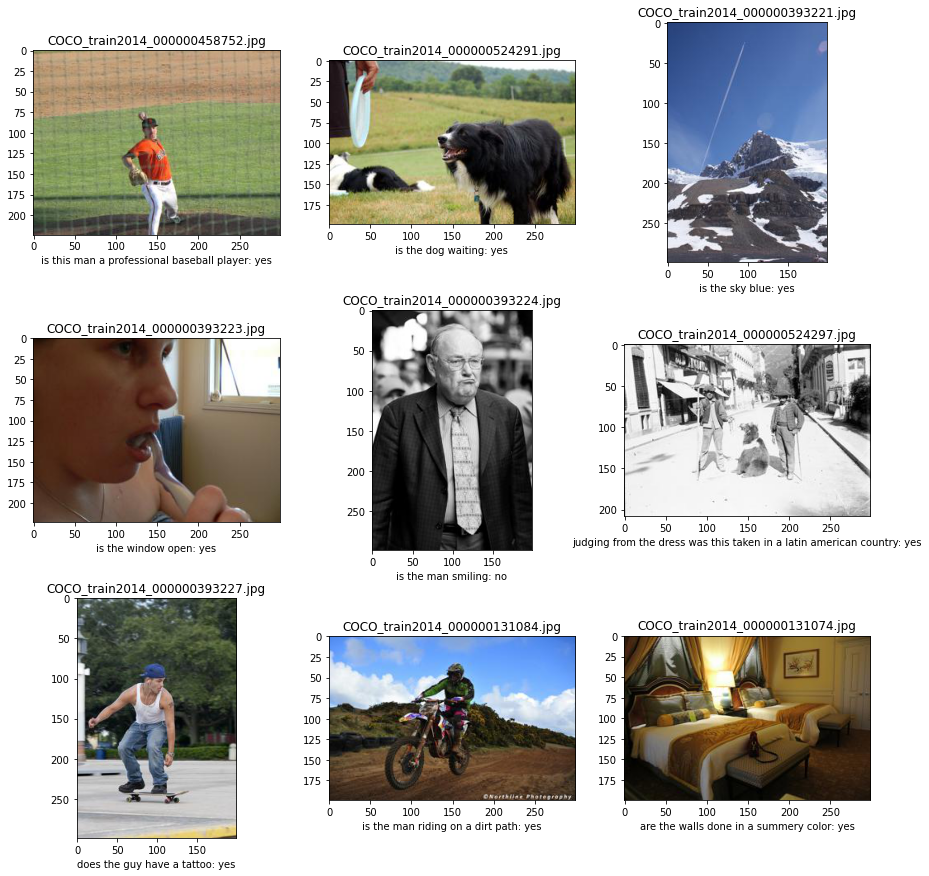

In [ ]:
# Your code here
data_dir = '/content/thumbnails'
starter_dir = '/content/starter2.csv'
train_pics = glob.glob(f"{data_dir}/*.jpg")

plt.figure(figsize=(15, 15))
for i in range(9):
    pic_file = df.iloc[i]['picture']
    ax = plt.subplot(3, 3, i + 1)
    for j in range(len(train_pics)):
        if pic_file in train_pics[j]:
            pic_ary = Image.open(train_pics[j])
            plt.imshow(pic_ary)
            plt.title(pic_file)
            plt.xlabel(f"{df.iloc[i]['question']}: {df.iloc[i]['Answer']}")

### Convert answers to numeric format

The answers in the starter CSV are "yes" or "no". For convenience, now would be a good time to change those to 1.0 and 0.0.

In [ ]:
# Your code here
# Convert the answers column in the starter CSV to 1.0 and 0.0
# You do not need to update the CSV itself. If you have a data structure
# in memory, you can work with that instead.
df['Answer'] = df['Answer'].map({'yes': 1.0, 'no': 0.0})
print(df.shape)
df.head()


(20000, 3)


,question,Answer,picture
0,is this man a professional baseball player,1.0,COCO_train2014_000000458752.jpg
1,is the dog waiting,1.0,COCO_train2014_000000524291.jpg
2,is the sky blue,1.0,COCO_train2014_000000393221.jpg
3,is the window open,1.0,COCO_train2014_000000393223.jpg
4,is the man smiling,0.0,COCO_train2014_000000393224.jpg


### Optional: Convert image names to absolute paths

Next, for convenience, it may be helpful to update the images column in the starter CSV from filenames ```COCO_train2014_000000320111.jpg``` to absolute paths ```/content/images/COCO_train2014_000000320111.jpg```. This will save you some code down the road when it comes time to open them up (you won't need to worry about the relationship between where the starter CSV file is stored, and your images folder).

In [ ]:
# Your code here
# Convert the image filenames in the starter CSV to absolute paths
# You do not need to update the CSV itself. If you have a data structure
# in memory, you can work with that instead.


### Shuffle and create a test set
For this assignment, you do not need to download the COCO validation or test sets. Instead, shuffle your starter CSV, and use some of the rows as a test set (say, 4,000 rows). Move them to a separate CSV or data structure, and revisit them later. We realize some of the same images may appear in the train and test set (although with different questions). For this assignment, that's okay. If you prefer, you can write code to ensure the test set has unique images that do not appear in the train set.

In [ ]:
# Your code here
# Shuffle the starter CSV
# Remove 4,000 rows (or so) and move them to a separate file or data structure

X = df[['picture','question']]
y = df['Answer']

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Limit the size of the dataset, and balance

**Update 11/1/2022: The starter dataset you downloaded is already balanced and limited in size, so you can skip this step**. Next, limit the size of the dataset, and balance. The dataset is fairly large. Let's simplify and start small. Instead of working with +/-100,000 questions, a better number would be about 20,000. As a suggestion, you may also want to balance the data (so you have an equal number of positive and negative questions), just to make it a bit easier to debug your model and verify it's training as expected.

In [ ]:
# Update: You can skip this step.
# Your code here
# Limit the size of the starter CSV to 20,000 rows
# Balance the data (so you have an equal number of "yes" and "no" answers)
# in your 20,000 rows

### Create training and validation sets
You may want to do an 80:20 split on your balanced training set, giving you 16,000 training rows, and 4,000 validation rows.

In [ ]:
# Your code here
# The scikit-learn utilities (train_test_split) are your friend

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, random_state=42)

### Optional: Verify your train and validation sets look as expected
Coding defensively often pays off (especially when working with increasingly complicated datasets and models). It is not possible to debug a complicated model without confidence in the data going into it.

In [ ]:
# Your code here.
print(f'the size of the training dataset is: {X_train.shape[0]}')
print(f'the size of the validation dataset is: {X_val.shape[0]}')
print(f'the size of the test dataset is: {X_test.shape[0]}')
print(f'the total size of the dataset is: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}')

the size of the training dataset is: 12800
the size of the validation dataset is: 3200
the size of the test dataset is: 4000
the total size of the dataset is: 20000



### Forward your images through InceptionV3 and cache activations to disk

Rather than training a CNN from scratch for your VQA model, you'll begin by using activations from a pretrained model.  

* Instead of forward each image repeatedly through the model while training (which will be slow), you'll do that once and save the activations to disk.

* You're saving them to disk (rather than keeping them in memory) to accomodate different sizes of datasets down the road.

* If you use a different model, also make sure to adjust the preprocessing to match what the model expects.

This introduces a bit of complexity, but we wanted to include it so you can see an example of this pattern. We've written most of this code for you, but you should go through it and understand how it works. You can find an newer version of similar code [here](https://www.tensorflow.org/tutorials/text/image_captioning#optional_cache_the_image_features) if you're interested (just for reference for your projects).

In [ ]:
# Create a feature extraction model.
# You should not need to modify this (though you may, if you'd like
# to use a model other than Inception).
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
activations_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
# A method to load an image off disk and preprocess
# it appropriately for the model above.
# You should not need to modify this.
def preprocess_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (299, 299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
# You'll need to extract activations for every image in your train, validation,
# and test set. First, create a set of the absolute paths to all of these images
# (image_path_set).
image_path_set = set()

# Your code here
# Populate this with the absolute paths to all these images.

for file in os.listdir('/content/thumbnails'):
    image_path_set.add(os.path.join('/content/thumbnails', file))

print("Images to preprocess", len(image_path_set))
print("This make take a few minutes")

Images to preprocess 40000
This make take a few minutes


In [ ]:
# This cell will extract activations for each image and save them to disk
# in NumPy format. You should not need to modify this.

# Create a dataset to load each image off disk, and extract activations
image_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
image_dataset = image_dataset.map(
  preprocess_img,
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Loop over the datset, and save all activations to disk in NumPy format
for img_batch, path_batch in image_dataset:
  batch_features = activations_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

### Create lists of questions, answers, and images for your train, validation, and test set

At this point, you may be reading your starter CSV directly from disk, or you may have your own data structure in memory. Since many of the methods we'll call from this point forward take lists as input, you may find it helpful to create a data structure with three lists, that correspond to the columns from your starter CSV.

In [ ]:
# Your code here.
# Populate these for your training set.
# questions_train = [] # a list of absolute paths to images in your training set
# answers_train = [] # a list of questions in your training set
# images_train = [] # a list of answers (in numeric format) in your training set

# The order of these lists should match (e.g. the question, answer, and image
# from row i of your train split of the starter CSV should be
# questions_train[i], answers_train[i], images_train[i]).

images_train = [os.path.join('/content/thumbnails', file) for file in X_train['picture']]
questions_train = [q for q in X_train['question']]
answers_train = y_train.tolist()

In [ ]:
# Your code here. Populate these for your validation set.
# questions_val = []
# answers_val = []
# images_val = []

images_val = [os.path.join('/content/thumbnails', file) for file in X_val['picture']]
questions_val = [q for q in X_val['question']]
answers_val = y_val.tolist()

In [ ]:
# Your code here. Populate these for your test set
# questions_test = []
# answers_test = []
# images_test = []

images_test = [os.path.join('/content/thumbnails', file) for file in X_test['picture']]
questions_test = [q for q in X_test['question']]
answers_test  = y_test.tolist()

### Create and adapt a TextVectorization layer

Your model will use a LSTM to process the questions. You'll need to tokenize, vectorize, and pad your text before processing it with that layer. You can accomplish all of these with the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) preprocessing layer.

First, you'll want to limit the vocabulary size to a reasonable size (for example, the top 3,000 words). A larger size will make a higher accuracy possible, but complicate and slow your model.

In [ ]:
# YOUR CODE HERE
# Determine a reasonable size for the vocabulary
VOCAB_SIZE = 3000

Next, you'll want to determine a reasonable max sequence length. Advice, start with something short, so your model trains faster (maybe, between 10 and 20).

In [ ]:
# YOUR CODE HERE
# Determine a reasonable max sequenece length
MAX_SEQ_LEN = 12

In [ ]:
from tensorflow.keras.layers import TextVectorization

# You should not need to modify this code
int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN)

# Set up the layer by creating dataset containing only the training questions
train_qs_ds = tf.data.Dataset.from_tensor_slices(questions_train)
int_vectorize_layer.adapt(train_qs_ds)

In [ ]:
# Use the TextVectorization layer to prepare the training, val, and test questions
question_train_vec = int_vectorize_layer(questions_train).numpy()

In [ ]:
# YOUR CODE HERE
# Vectorize your validation and test sets.
# question_val_vec = ...
# question_test_vec = ...
question_val_vec = int_vectorize_layer(questions_val).numpy()
question_test_vec = int_vectorize_layer(questions_test).numpy()

### Sanity check
You've just done a **bunch** of preprocessing. Optionally, now would be a good time to write a block of code to display a few questions (in plaintext) and the results of vectorizing them with the layer above to verify the format is as you expect.

In [ ]:
# Your code here (optional).
for i in range(5):
    print(f'The question is: {questions_train[i]}')
    print(f'The vectorized question is: {question_train_vec[i]}')

The question is: are the waters calm
The vectorized question is: [   6    2 1939  847    0    0    0    0    0    0    0    0]
The question is: do you see the carrots
The vectorized question is: [ 20  21  38   2 502   0   0   0   0   0   0   0]
The question is: has the finger holding the fork had a manicure lately
The vectorized question is: [  46    2 1797   85    2  763  904    4    1    1    0    0]
The question is: are there people waiting for the train
The vectorized question is: [  6   8  19 227  26   2  42   0   0   0   0   0]
The question is: is there a statue in the middle of the square
The vectorized question is: [   3    8    4  566    7    2  356   11    2 1052    0    0]


### Create a tf.dataset for training, validation, and testing

The method to create the dataset is provided for you, though you will need to get it working by passing the ```images_train```, ```question_train_vec``` ```and answers_train``` lists you created above.

In [ ]:
# You should not need to modify this.
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
# You should not need to modify this.
# Load cached activations off disk.
def load_np(img_path, question, answer):
  activations = np.load(img_path.decode('utf-8')+'.npy')
  return activations, question, answer, img_path

In [ ]:
# You should not need to modify this.

# This method will create a dataset that returns four elements.
# - a batch of activations (loaded from disk)
# - a batch of padded questions
# - a batch of numeric answers
# - a batch of absolute paths to the corresponding images
def create_dataset(images, sequences, answers):
  dataset = tf.data.Dataset.from_tensor_slices((images,
                                                sequences,
                                                answers))
  # Load the cached activations off disk
  # Note: This is not the clearest code in the world (it's on our list to
  # update on the website from the example I borrowed it from,
  # so it's implemented for you in this assignment)
  dataset = dataset.map(lambda x, y, z: tf.numpy_function(
      load_np, [x, y, z], [tf.float32, tf.int64, tf.float32, tf.string]),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
# Your code here

# Call the above method to create train, val, and test datasets.
# If you want to follow along with the starter code, I suggest these
# variable names:

# train_ds = create_dataset(images_train, question_train_vec, answers_train)
# val_ds = ...
# test_ds = ...

train_ds = create_dataset(images_train, question_train_vec, answers_train)
val_ds = create_dataset(images_val, question_val_vec, answers_val)
test_ds = create_dataset(images_test, question_test_vec, answers_test)

### Sanity check (optional)
That dataset creation method is complicated. Write a block of code that demonstrates how to use the dataset (e.g., retrieve a batch of activations, questions, answers, and images paths) and verify they look as expected.

In [ ]:
# Your code here (optional)
# Verify your datasets are working properly

# Here is code you can use to quickly retrieve a batch of data

my_iterator = iter(train_ds)
activations_batch, questions_batch, answers_batch, paths_batch = next(my_iterator)

print(activations_batch.shape,
      questions_batch.shape,
      answers_batch.shape,
      paths_batch.shape)

(32, 8, 8, 2048) (32, 12) (32,) (32,)


### Define your VQA model

You can base your code off the example below.

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM
from tensorflow.keras.models import Model, Sequential

Visual question answering was one of the original advanced examples for Keras.

This model can select the correct one-word answer when asked a natural-language question about a picture.

It works by encoding the question into a vector, encoding the image into a vector, concatenating the two, and training on top a logistic regression over some vocabulary of potential answers (in the case of your assignment, just "yes" or "no".)

Keep in mind, this model is unnecessarily large for your dataset, and you should implement a simplified version in the code cell below.

```
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model, Sequential

# First, let's define a vision model using a Sequential model.
# This model will encode an image into a vector.
vision_model = Sequential()
vision_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
vision_model.add(Conv2D(64, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(128, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(Conv2D(256, (3, 3), activation='relu'))
vision_model.add(MaxPooling2D((2, 2)))
vision_model.add(Flatten())

# Now let's get a tensor with the output of our vision model:
image_input = Input(shape=(224, 224, 3))
encoded_image = vision_model(image_input)

# Next, let's define a language model to encode the question into a vector.
# Each question will be at most 100 word long,
# and we will index words as integers from 1 to 9999.
question_input = Input(shape=(100,), dtype='int32')
embedded_question = Embedding(input_dim=10000, output_dim=256, input_length=100)(question_input)
encoded_question = LSTM(256)(embedded_question)

# Let's concatenate the question vector and the image vector:
merged = keras.layers.concatenate([encoded_question, encoded_image])

# And let's train a logistic regression over 1000 words on top:
output = Dense(1000, activation='softmax')(merged)

# This is our final model:
vqa_model = Model(inputs=[image_input, question_input], outputs=output)
```

In [ ]:
# Your code here
# Below is starter code for your model for you to complete.
# See above for the idea.
# The vision model is written for you. You will need to write the question model.

# This is the input to your vision model (activations from Inception-V3,
# loaded off disk disk by the dataset above).
image_input = Input(shape=(8, 8, 2048))
vision_model = Sequential()

# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())

# Output of your vision model
encoded_image = vision_model(image_input)

# Your code here
# Write your test processing model that takes the vectorized question as input.
# As in the example above, you will want to produce an `encoded_question`
# as output
# For the encoded question, you may want to experiment with a
# Bidirectional LSTM
# https://keras.io/api/layers/recurrent_layers/bidirectional/
question_input = Input(shape=(MAX_SEQ_LEN,), dtype='int32')
embedded_question = Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_SEQ_LEN)(question_input)
encoded_question = LSTM(256)(embedded_question)

# Concatenate the encoded image and question
merged = tf.keras.layers.concatenate([encoded_image, encoded_question])

# Optionally, add a small dense layer
# dense = ...

# Next, add a binary classifier on top
output = Dense(1, activation='sigmoid')(merged)

# Your final model
model = Model(inputs=[image_input, question_input], outputs=output)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 embedding_1 (Embedding)        (None, 12, 256)      768000      ['input_5[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 2048)         0           ['input_4[0][0]']          

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Plot your model
Create a schematic that shows the graph of your model, using [plot_model](https://keras.io/visualization/). This can be helpful to ensure the vision and question paths look at expected (it's also super cool, and more informative than .summary).

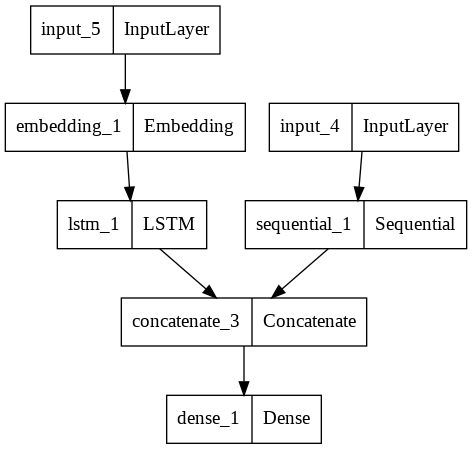

In [ ]:
# You should not need to modify this.
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Fit your model on a single batch
Before training on your entire dataset, a helpful first step is to train repeatedly on a single batch, and verify the loss goes to zero. If your model is working properly, it should be able to memorize a batch of data. We will use ```model.train_on_batch``` for this.

In [ ]:
# You should not nee to modify this.
# Retrieve a batch of data from your train dataset
activations_batch, questions_batch, answers_batch, paths_batch = next(iter(train_ds))

In [ ]:
# Your code here

# Train them model repeatedly using model.train_on_batch
# Verify the loss goes to zero after +/- 100 training steps.
# If it does not, now would be a great time to debug
# before proceeding further.

# e.g.
# metrics = model.train_on_batch ....
# metrics is a list (loss is metrics[0], accuracy is metrics[1])

loss_one_batch = []
accuracy_one_batch = []

for i in range(100):
    metrics = model.train_on_batch([activations_batch, questions_batch], answers_batch)
    loss_one_batch.append(metrics[0])
    accuracy_one_batch.append(metrics[1])

Text(0, 0.5, 'accuracy')

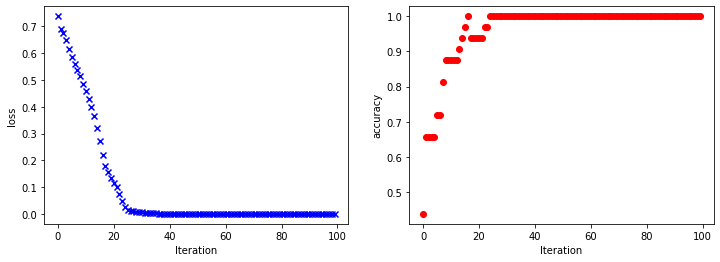

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

x = np.arange(0, 100, 1)

ax[0].scatter(x, loss_one_batch,marker='x',color='blue');
ax[1].scatter(x, accuracy_one_batch,color='red');

ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

# ax[0].set_title('trip_distance vs fare_amount')
# ax[1].set_title('trip_distance vs tip_amount')

### Use your model to make predictions on the same batch above
Compare the predicted answer to the label. Verify they match.

In [ ]:
# You should not need to modify this, but you will want to
# carefully inspect the output.
for prediction, answer in zip(model.predict(x=[activations_batch, questions_batch]), answers_batch):
  print(prediction, answer.numpy())

1/1 [==============================] - 0s 28ms/step
[0.9999821] 1.0
[0.9999291] 1.0
[0.99997365] 1.0
[3.123767e-05] 0.0
[0.00015243] 0.0
[6.572272e-05] 0.0
[0.00015384] 0.0
[2.063983e-05] 0.0
[7.5863296e-05] 0.0
[2.842763e-05] 0.0
[5.9107842e-05] 0.0
[8.1895654e-05] 0.0
[0.9999033] 1.0
[9.829792e-05] 0.0
[0.999954] 1.0
[9.1428235e-05] 0.0
[4.9529608e-05] 0.0
[3.3273478e-05] 0.0
[0.999967] 1.0
[4.099039e-05] 0.0
[0.99962974] 1.0
[0.9999473] 1.0
[0.00011026] 0.0
[0.00012455] 0.0
[7.570373e-05] 0.0
[0.99980265] 1.0
[3.6449674e-05] 0.0
[0.00020849] 0.0
[8.296292e-05] 0.0
[2.257468e-05] 0.0
[0.999951] 1.0
[0.9997924] 1.0


### Create a checkpoints directory

Once you have been able to train your model on a single batch, it's time to begin training on your training dataset. It may take a while to train for a single epoch, and it would be unfortunate if Colab disconnected after training for a while, and you lost your progress.

* After each training epoch, save the model's weights in a checkpoint file. You can learn more about how to create checkpoints [here](https://www.tensorflow.org/guide/keras/save_and_serialize).

* To resume training, load the latest checkpoint from disk. This will restore the latest weights and resume your progress. If it does not exist, begin training from scratch.

* As a tip, you may want to store your checkpoints in Google Drive, so you'll still have access to them if Colab disconnects.

Note that running long jobs is not what Colab is intended for. Normally, you could simple save your checkpoints on the machine you're working on. Saving to drive adds an extra step, but it's worthwhile learning how to do.

Saving checkpoints to drive is optional, you can save them to Colab for this assignment if you prefer and receive full credit.

Tip: if you do decide to use  Drive, **do not** programmatically run any commands to delete files from your checkpoints folder or elsewhere (e.g., by using ```!rm -rf```) in Colab. If you're not careful, you may accidentally wipe out your entire drive if you make a programming mistake!

* Instead, if you need to delete checkpoints, do so manually through the drive user interface. Note that files deleted through the UI may take a minute or so to "actually" be deleted as reflected by ```!ls``` commands run from Colab.

In [ ]:
# If you would like to save checkpoints in drive (optional), you can uncomment
# the code below. Otherwise, this notebook will save checkpoints in Colab,
# which is okay for this assignment.

## Mount Google Drive
# from google.colab import drive
# drive.mount('/gdrive')
# drive_root = '/gdrive/My Drive/'

## Save checkpoints to Colab by default
drive_root = "/content/drive/MyDrive/Colab_Notebooks/ADL_HW3/Model"

In [ ]:
# This code will save checkpoints in drive.
# Alternatively, you can modify it to save
# checkpoints in Colab (these will not persist if your instance is terminated,
# but you can manually download them if you like).
checkpoint_dir = os.path.join(drive_root, "checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "hw4")

# Used for formatting
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

### Restore the latest checkpoint (if it exists).

In [ ]:
# You should not need to modify this code.
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Checkpoint not found. Starting from scratch


### Metrics

In [ ]:
# Utilities to help us record metrics.
# You should not need to modify this code
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.BinaryCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')

### Code to evaluate on the validation dataset
The validation dataset may be large. It would be wasteful to evaluate on the entire validation dataset each training epoch. Instead, you could evaluate every N epochs, or, you can use the below methoid to evaluate for a fixed number of steps (batches). This will give you a noisier evaluation, but a useful indicator of how your model is doing over time.

In [ ]:
# You should not need to modify this.
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, question_batch, answer_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=[activation_batch, question_batch])
    steps += 1
    # Record metrics after each batch
    val_loss(answer_batch, predictions)
    val_accuracy(answer_batch, predictions)

### Train the model
As before, we'll write our training loop using ```train_on_batch```. This is intermediate in complexity between using ```.fit``` and writing everything from scratch using a ```GradientTape```. Because we're not using ```.fit```. Since we're not using .fit, there's a bit of extra code we need to write ourselves to track loss and accuracy as we go.

In [ ]:
# Your code here
# Complete this cell (there are only a few parts to write)

# Used to track loss and accuracy as we go
# You should not need to modify these
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 10 # Your code here

# Training loop
for epoch in range(epochs):

  start = time.time()

  # Train for one epoch
  for activation_batch, question_batch, answer_batch, path_batch in train_ds:
    result = model.train_on_batch(x=[activation_batch, question_batch], y=answer_batch)

    # Record metrics after each batch
    train_loss(result[0])
    train_accuracy(result[1])

  # Evaluate for a few steps
  evaluate(max_steps=100)

  # Print progress
  # You should not need to modify this.
  template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
  print(template.format(epoch,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        val_loss.result(),
                        val_accuracy.result() * 100,
                        time.time() - start))

  # Record history
  train_loss_history.append(train_loss.result())
  train_acc_history.append(train_accuracy.result() * 100)
  val_loss_history.append(val_loss.result())
  val_acc_history.append(val_accuracy.result() * 100)

  # Reset the metrics for the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Your code here
  # Save a checkpoint after each epoch
  print("Saving weights")
  # model.save_weights ...
  model.save_weights(checkpoint_path)

1/1 [==============================] - 0s 32ms/step
Epoch 0, Loss: 0.76, Accuracy: 50.77, Val Loss 0.70, Val Accuracy 52.41, Time: 96.3 secs
Saving weights
1/1 [==============================] - 0s 31ms/step
Epoch 1, Loss: 0.68, Accuracy: 57.25, Val Loss 0.71, Val Accuracy 54.47, Time: 59.3 secs
Saving weights
1/1 [==============================] - 0s 30ms/step
Epoch 2, Loss: 0.61, Accuracy: 67.05, Val Loss 0.74, Val Accuracy 54.88, Time: 59.6 secs
Saving weights
1/1 [==============================] - 0s 27ms/step
Epoch 3, Loss: 0.54, Accuracy: 72.42, Val Loss 0.78, Val Accuracy 53.53, Time: 96.2 secs
Saving weights
1/1 [==============================] - 0s 34ms/step
Epoch 4, Loss: 0.48, Accuracy: 76.45, Val Loss 0.86, Val Accuracy 54.84, Time: 59.2 secs
Saving weights
1/1 [==============================] - 0s 26ms/step
Epoch 5, Loss: 0.43, Accuracy: 79.01, Val Loss 1.04, Val Accuracy 53.41, Time: 60.0 secs
Saving weights
1/1 [==============================] - 0s 31ms/step
Epoch 6, Los

### Create plots of your training and validation loss and accuracy

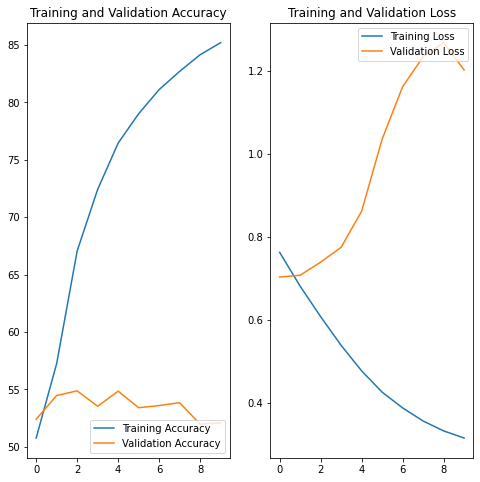

In [ ]:
# Your code here


acc = train_acc_history
val_acc = val_acc_history

loss = train_loss_history
val_loss = val_loss_history

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### At this point, you have end-to-end code to train VQA model
Now you can begin working on increasing accuracy. For this assignment, your model should at least be able to fit your training set reasonably well.

Given the amount of data we're using, you do **not** need to build a model that performs well on validation to receive full credit for this asignment (I recently made the starter dataset a bit more difficult, as a result - you may need to train using more data than I want you to use for a homework assignment, so no worries).

### Finally, evaluate your model on the test set
How well did it do? This assignment is lengthy. For our purposes, it's fine to report the accuracy - and you're done :)

For a proper evaluation, take a look at this [paper](https://arxiv.org/abs/1612.00837), as discussed in class.

Note: if your model is performing poorly on the test set, you can still receive full credit for this assignment as mentioned above.

In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from /content/drive/MyDrive/Colab_Notebooks/ADL_HW3/Model/checkpoints/hw4/cp-{epoch:08d}.ckpt


In [ ]:
# Your code here
# Calculate accuracy on the test set

total = 0
erorr = 0
for activation_batch, question_batch, answer_batch, path_batch in test_ds:
    for prediction, answer in zip(model.predict(x=[activations_batch, questions_batch]), answers_batch):
        total +=1
        prediction = 0 if prediction <= 0.5 else 1
        if prediction != answer.numpy():
            erorr +=1
accuracy = 1 - (erorr/total)
print(f'The accuracy of the model is is: {accuracy:0.2f}')

1/1 [==============================] - 0s 26ms/step
The accuracy of the model is is: 0.84


Phew, that's it! This was a long assignment, I hope it was a useful (and fun!) experience.